### Dataset Information

IMDB dataset contains 50K movie reviews for natural language processing i.e.  for binary sentiment classification. A set of 25,000 highly polar movie reviews for training and 25,000 for testing is provided. The dataset contains two columns - review and sentiment i.e. review and sentiment to perform the sentimental analysis.

### Problem Statement
Choosing the best algorithm over a set of algorithms to predict the number of positive and negative reviews.

### Importing Libraries

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata

### Data Extraction

In [2]:
data=pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
data.describe() #descriptive statistics

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


There might be 50000 - 49582 = 418 duplicated reviews

In [5]:
#identify duplicates
data.duplicated().sum()

418

In [6]:
#place duplicated reviews side by side 
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


418 duplicate reviews are present

In [7]:
data.drop_duplicates(inplace = True)

In [8]:
data.shape

(49582, 2)

In [9]:
#identifying missing values
data.isnull().sum()

review       0
sentiment    0
dtype: int64

### Data Cleaning

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wl = nltk.WordNetLemmatizer()

In [11]:
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text =  re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    tokens = re.split('\W+', text) #create tokens
    text = [wl.lemmatize(word) for word in tokens if word not in stopwords and word.isalpha()] #lemmatize
    return text

In [12]:
data['review']=data['review'].apply(clean_text)

In [13]:
data.head()

,review,sentiment
0,"[one, reviewer, mentioned, watching, oz, episo...",positive
1,"[wonderful, little, production, filming, techn...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, there, family, little, boy, jake, ...",negative
4,"[petter, matteis, love, time, money, visually,...",positive


In [14]:
#converting target variable to numerical value
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [15]:
data.head()

,review,sentiment
0,"[one, reviewer, mentioned, watching, oz, episo...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[thought, wonderful, way, spend, time, hot, su...",1
3,"[basically, there, family, little, boy, jake, ...",0
4,"[petter, matteis, love, time, money, visually,...",1


### Exploratory data analysis

C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of positive and negative IMBD reviews')

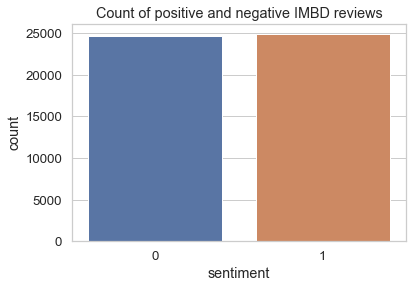

In [16]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(data.sentiment)
plt.title('Count of positive and negative IMBD reviews')

In [17]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


In [18]:
data['sentiment'].value_counts()

1    24884
0    24698
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Word cloud for positive reviews')

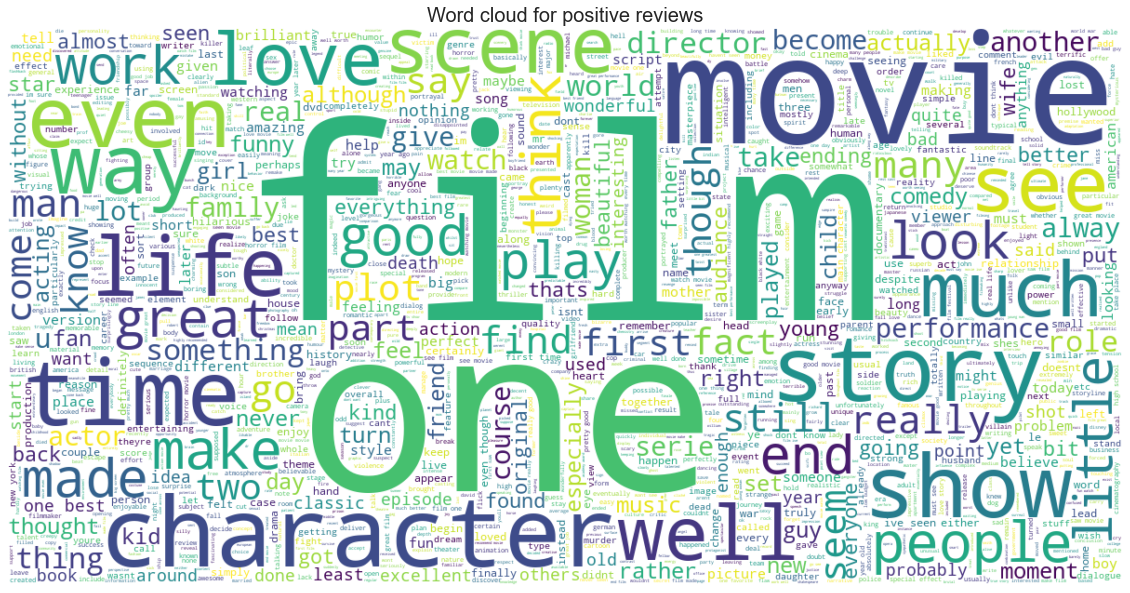

In [19]:
#word cloud for positive reviews
positive_data = data[data.sentiment == 1]['review']
positive_data_string = ' '.join(np.concatenate(np.array(positive_data)))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)

Text(0.5, 1.0, 'Word cloud for negative reviews')

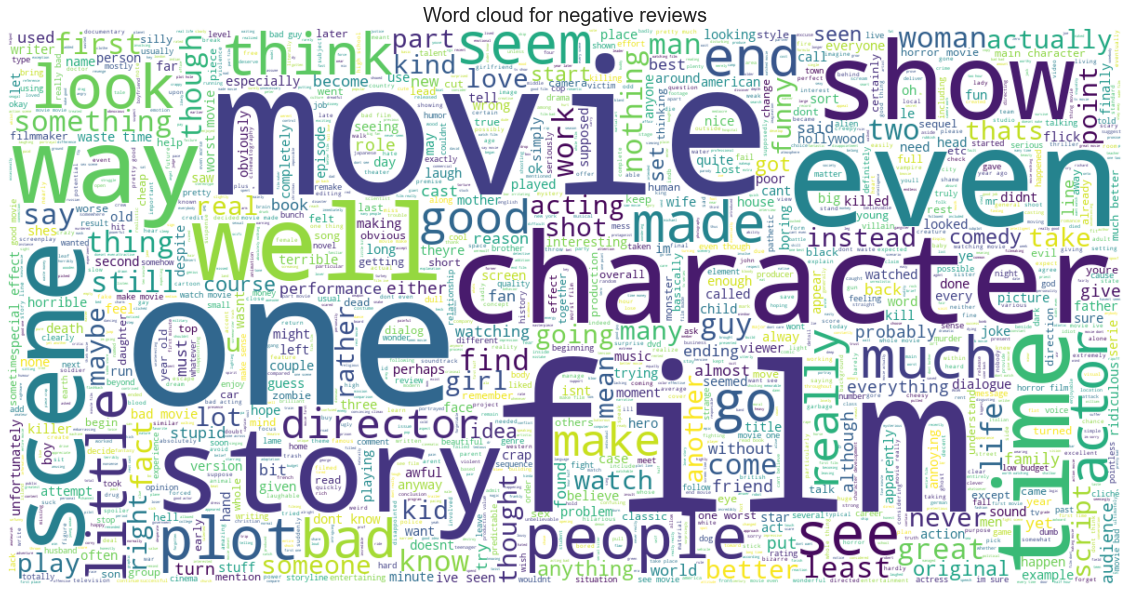

In [20]:
#word cloud for negative reviews
negative_data = data[data.sentiment == 0]['review']
negative_data_string = ' '.join(np.concatenate(np.array(negative_data)))
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)

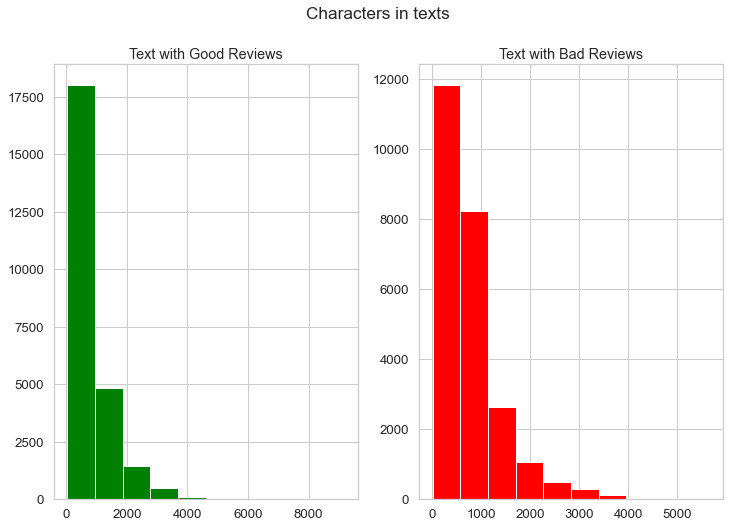

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
join_positive = positive_data.str.join(" ")
text_len=join_positive.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
join_negative = negative_data.str.join(" ")
text_len=join_negative.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

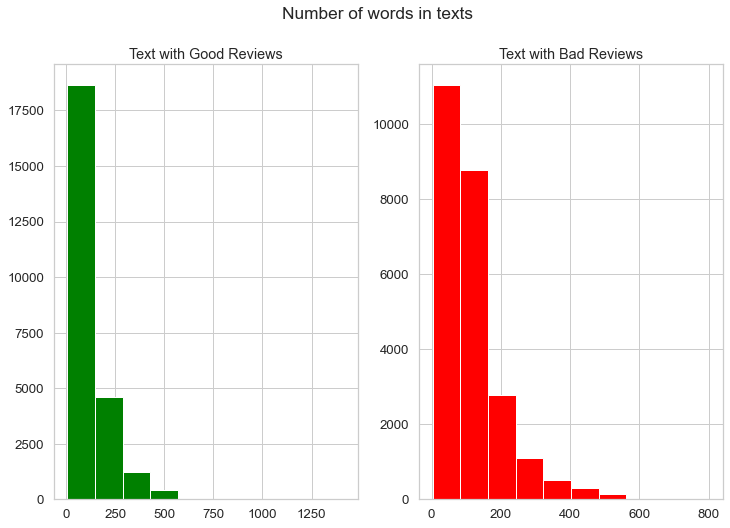

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Text with Good Reviews')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Number of words in texts')
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Distribution of number of words per reviews')

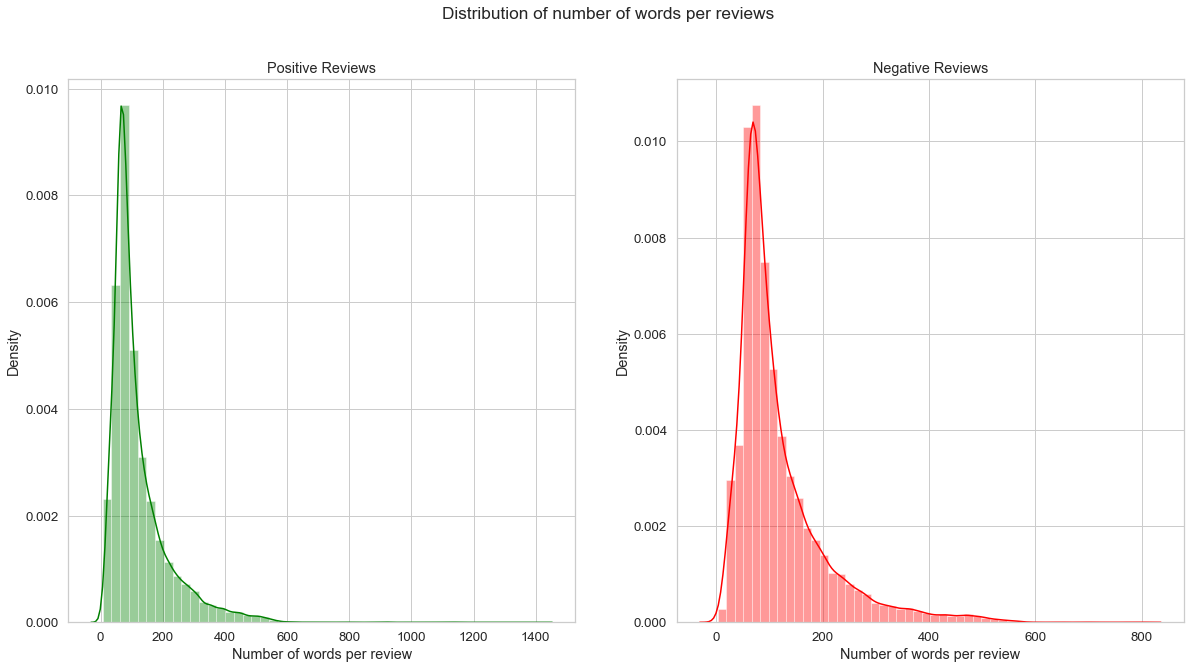

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.apply(lambda x : len(x))
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.apply(lambda x : len(x))
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Distribution of average word length in each review')

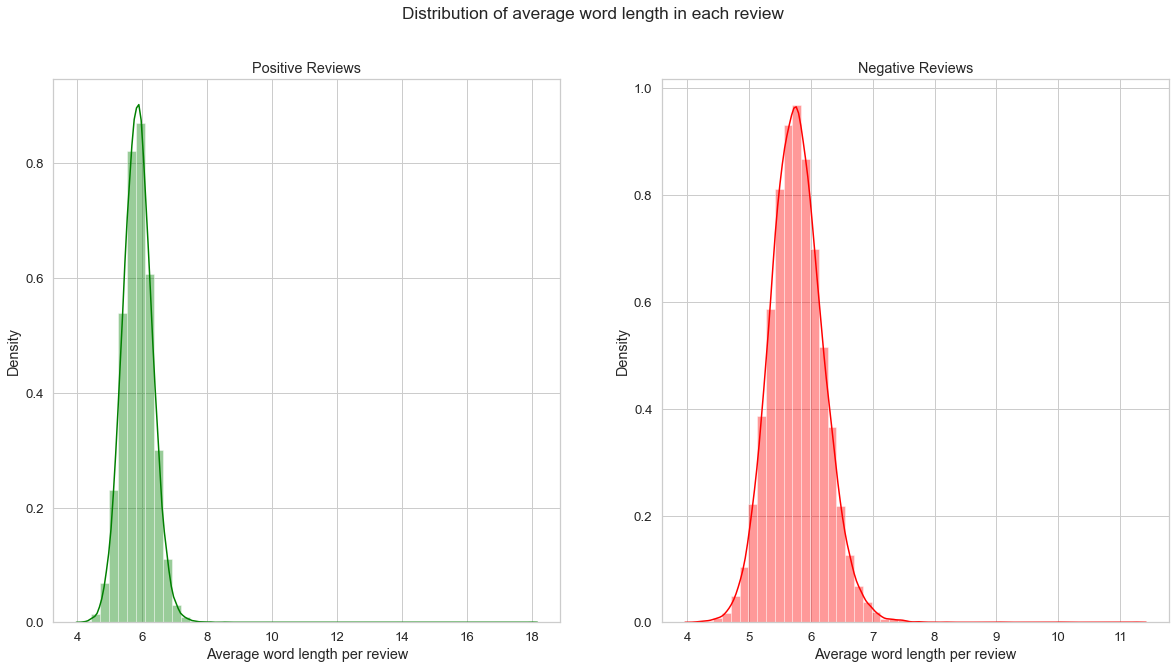

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')

In [25]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i:
            words.append(j)
    return words
corpus = get_corpus(data.review)
corpus[:5]

['one', 'reviewer', 'mentioned', 'watching', 'oz']

In [26]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 100617,
 'film': 91147,
 'one': 53535,
 'like': 39751,
 'time': 30097,
 'good': 28905,
 'character': 27806,
 'story': 24603,
 'even': 24445,
 'get': 24330}

In [27]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

Text(0.5, 0.98, 'Unigram analysis for positive and negative reviews')

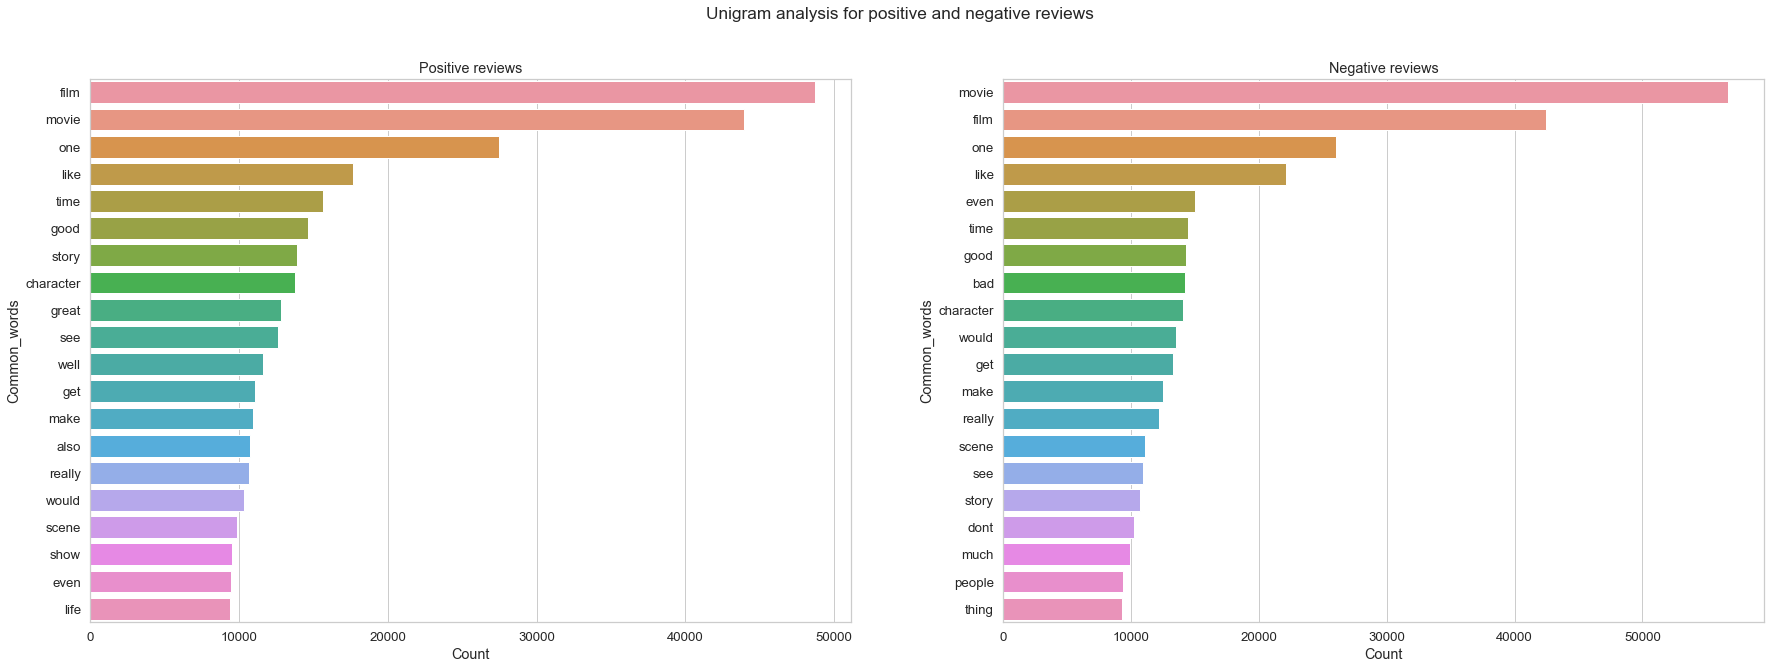

In [28]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,10))
uni_positive = get_ngrams(join_positive,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(join_negative,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')


Text(0.5, 0.98, 'Bigram analysis for positive and negative reviews')

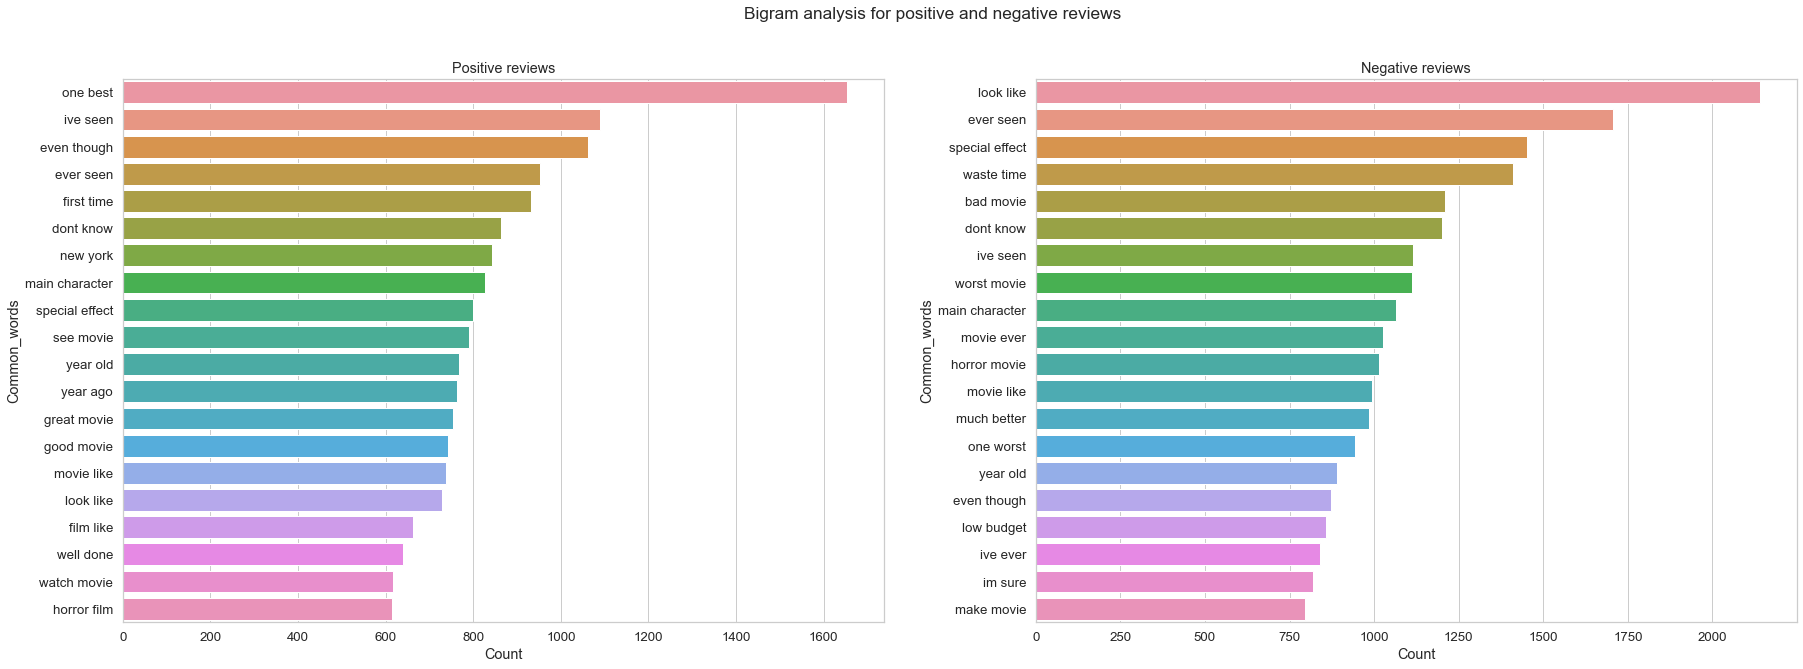

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,10))
bi_positive = get_ngrams(join_positive,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(join_negative,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')

Text(0.5, 0.98, 'Trigram analysis for positive and negative reviews')

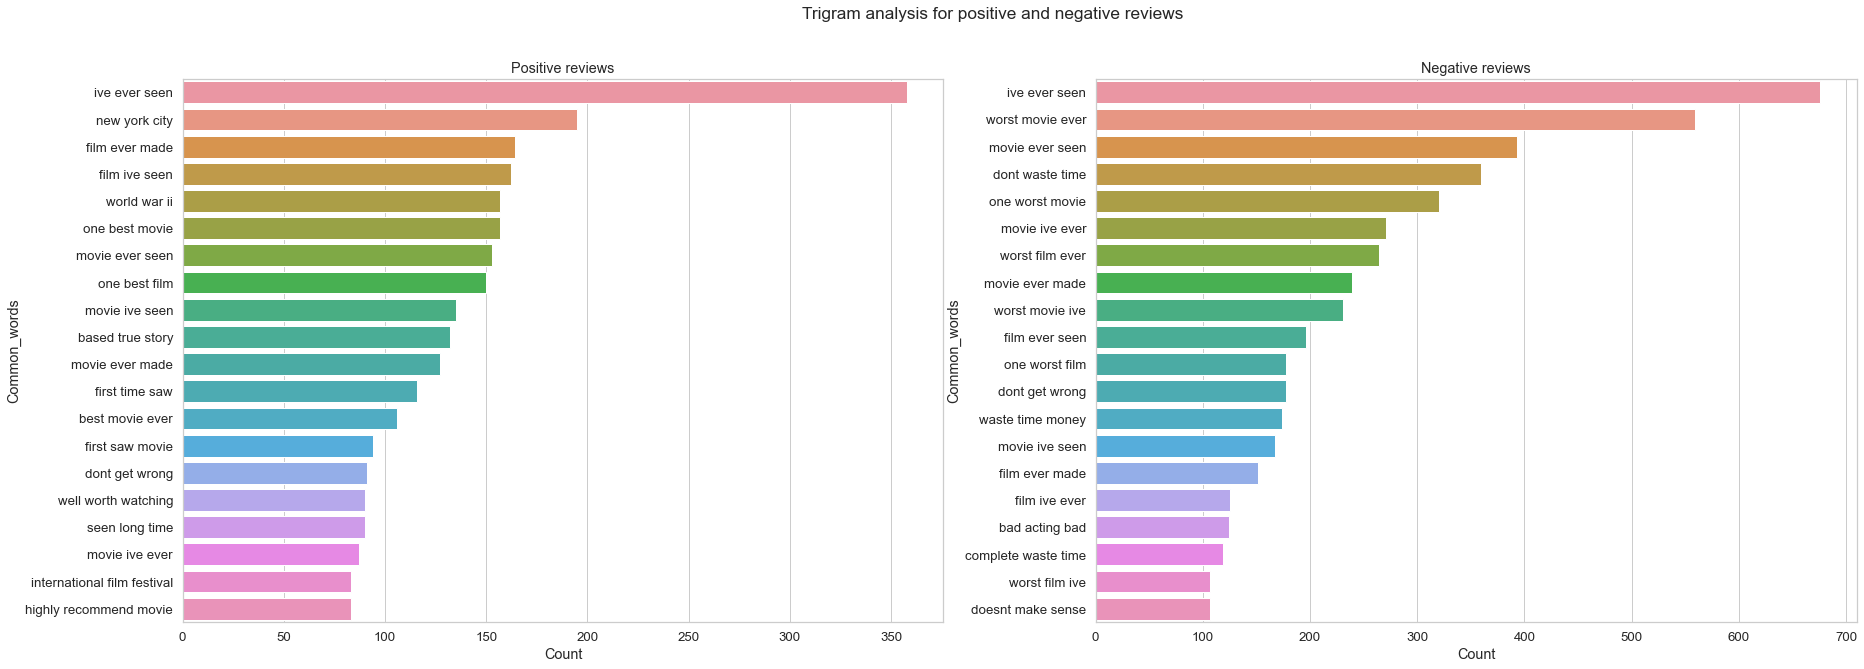

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,10))
tri_positive = get_ngrams(join_positive,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(join_negative,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')

In [17]:
#splitting into train and test
join_reviews = data['review'].str.join(" ")
data['review'] = join_reviews
train, test= train_test_split(data, test_size=0.33, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

### Vectorizing data

In [18]:
#tfidfVectorizer
tfidf_vect = TfidfVectorizer()
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)

# CountVectorizer
count_vect = CountVectorizer()
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

### Predictive Modelling

Logistic regression accuracy : 89.16%


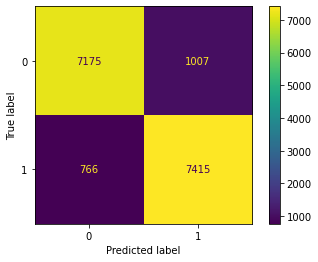

In [18]:
#logistic regression
lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(lr, Xtest_tfidf, ytest)
plt.show()

In [20]:
print(classification_report(p1,ytest))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7941
           1       0.91      0.88      0.89      8422

    accuracy                           0.89     16363
   macro avg       0.89      0.89      0.89     16363
weighted avg       0.89      0.89      0.89     16363



Multinomial Naive Bayes Classifier Accuracy : 86.51%


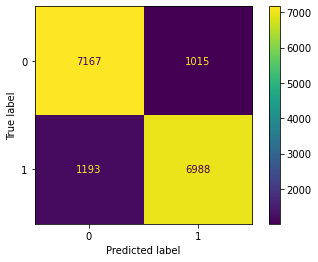

In [38]:
#Multinomial Naive Bayes
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(nb, Xtest_tfidf, ytest)
plt.show()

Linear Support Vector Classifier Accuracy : 89.45%


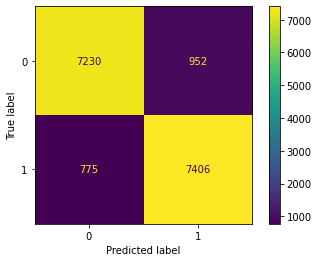

In [36]:
#Linear SVM
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))
plot_confusion_matrix(linear_svc, Xtest_tfidf, ytest)
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Accuracy : 85.13%


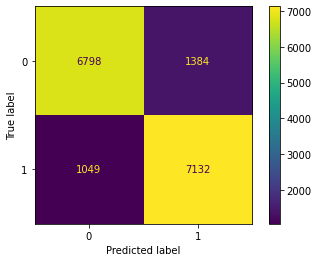

In [21]:
#XGboost classifier
xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf,ytrain)
p4=xgbo.predict(Xtest_tfidf)
s4=accuracy_score(ytest,p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100*s4))
plot_confusion_matrix(xgbo, Xtest_tfidf, ytest)
plt.show()

### Predictive Modelling using Deep Learning
----------to be continued